In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [3]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


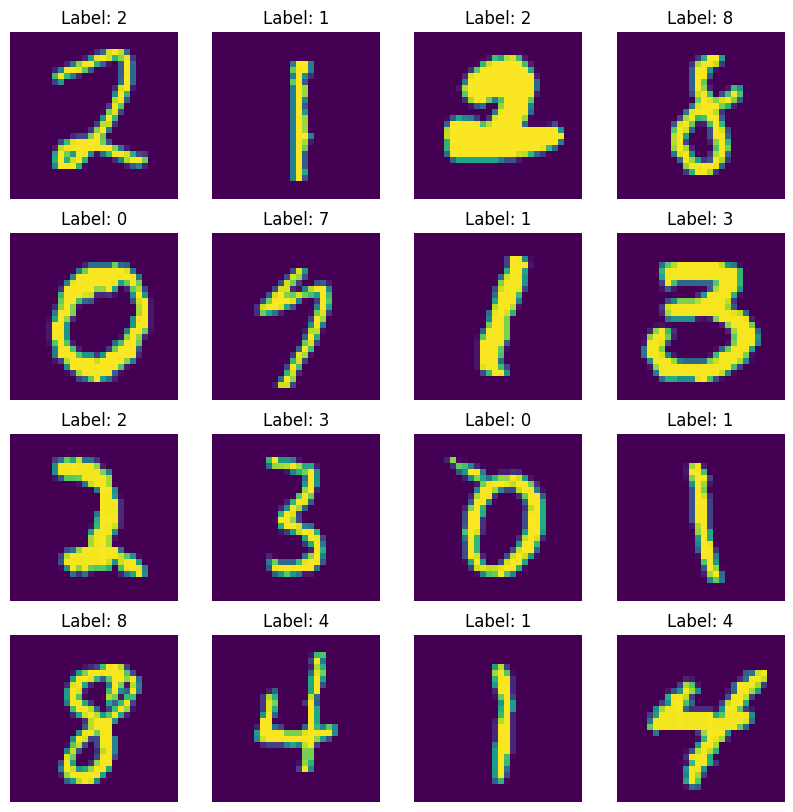

In [4]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [5]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2 = params

    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x

# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2])


In [6]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.2499, -0.6417,  0.0157,  0.4872, -0.6365],
        [ 1.7140, -0.2974,  0.4400,  0.4149,  0.3250],
        [ 1.0219, -1.5335, -0.9782,  1.4677, -2.0748]], requires_grad=True)

In [32]:
def check_accuracy(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    # print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [33]:
def train(model_fn, params, learning_rate, print_every=100):
    w1, w2, m1, m2 = params
    
    last_accuracy = 0   
    
    for t, (x, y) in enumerate(loader_train):
        
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            
        scores = model_fn(x, [w1, w2])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            w1.grad.zero_()
            w2.grad.zero_()

        if t % print_every == 0:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
            with torch.no_grad():
                w1 *= m1
                w2 *= m2
            
            last_accuracy = check_accuracy(loader_val, model_fn, [w1, w2])
            print()
            
    return last_accuracy

In [36]:
# import random
# hidden_layer_size = 500
# learning_rate = 1e-2

# w1 = random_weight((28 * 28, hidden_layer_size))
# w2 = random_weight((hidden_layer_size, 10))

# initial_w1 = w1.clone().detach().requires_grad_(False)
# initial_w2 = w2.clone().detach().requires_grad_(False)

    
# all = []    

# for k in range(30):
    
#     m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
#     m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)
    
    
#     num_elements = int(0.1 * m1.numel())
#     m1_flat = m1.view(-1)
#     indices = random.sample(range(m1_flat.numel()), num_elements)
#     m1_flat[indices] = 0
#     m1 = m1_flat.view(m1.size()) 

#     num_elements = int(0.1 * m2.numel())
#     m2_flat = m2.view(-1)
#     indices = random.sample(range(m2_flat.numel()), num_elements)
#     m2_flat[indices] = 0
#     m2 = m2_flat.view(m2.size())

#     with torch.no_grad():
#         w1 *= m1
#         w2 *= m2

#     all.append(check_accuracy(loader_val, two_layer_fc, [w1, w2]))

#     w1 = initial_w1.clone().detach().requires_grad_(True)
#     w2 = initial_w2.clone().detach().requires_grad_(True)
    
    


In [37]:
import random
hidden_layer_size = 500
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

initial_w1 = w1.clone().detach().requires_grad_(False)
initial_w2 = w2.clone().detach().requires_grad_(False)

m1_init = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2_init = torch.ones((hidden_layer_size, 10), dtype=dtype)
    
last_masks = [(m1_init, m2_init, check_accuracy(loader_val, two_layer_fc, [w1, w2]))]

for iter in range(100):
    next_masks = []
    
    for m1, m2, _ in last_masks:
        for k in range(30):
            num_elements = int(0.1 * m1.numel())
            m1_flat = m1.view(-1)
            indices = random.sample(range(m1_flat.numel()), num_elements)
            
            
            m1_flat[indices] = 1 - m1_flat[indices]
            m1 = m1_flat.view(m1.size()) 
            
            num_elements = int(0.1 * m2.numel())
            m2_flat = m2.view(-1)
            indices = random.sample(range(m2_flat.numel()), num_elements)
            m2_flat[indices] = 1 - m2_flat[indices]
            m2 = m2_flat.view(m2.size())
            
            with torch.no_grad():
                w1 *= m1
                w2 *= m2
                
            next_masks.append((m1, m2, check_accuracy(loader_val, two_layer_fc, [w1, w2])))
            
            w1 = initial_w1.clone().detach().requires_grad_(True)
            w2 = initial_w2.clone().detach().requires_grad_(True)
    
    print(next_masks)
    last_masks = last_masks + next_masks
    last_masks.sort(key=lambda x: x[2], reverse=True)
    last_masks = last_masks[:10]
    
    print(last_masks[0][2])
    



0.1572
0.189
0.199
0.2055
0.2055
0.2055
0.2083
0.2083


KeyboardInterrupt: 

In [38]:
print(last_masks)

[(tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 1., 0., 0.]]), tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 0.]]), 0.2083), (tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 1., 0., 0.]]), tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1

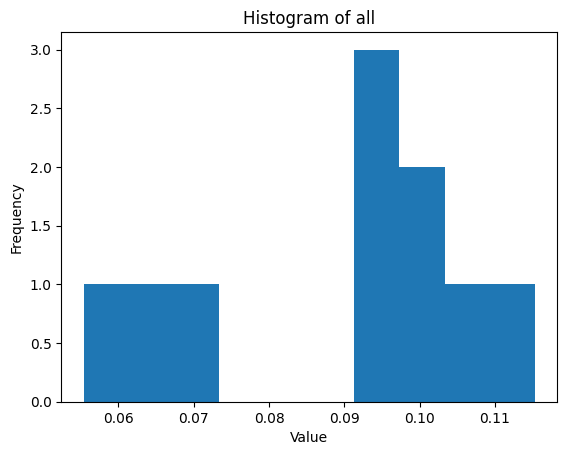

In [22]:
plt.hist(all)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of all')
plt.show()
